### Underlying Data Stuff

All the stuff needed to represent the algorithm; like the basic datatypes and some helpers are here.

In [1]:
## Path Class definition.

class Path:
    edges: list
    nodes: list

    def __init__(self):
        self.edges = []
        self.nodes = []

    def add_edge(self, edge):
        self.edges.append(edge)

    def add_edges(self, edges):
        self.edges.extend(edges)

    def add_node(self, node):
        self.nodes.append(node)

    def add_nodes(self, nodes):
        self.nodes.extend(nodes)

In [2]:
## Node Class definition.

class Node:
    x: float
    y: float

    def __init__(self, x, y):
        self.x = x
        self.y = y

In [3]:
## Edge Class definition.

class Edge:
    start: Node
    end: Node

    def __init__(self, start_node, end_node):
        self.start = start_node
        self.end = end_node

### Algorithm Stuff

Anything pertaining to the actual algorithm (along with helper methods) I've come up with is in here.

The algorithm starts with a simple process:

1. Choose a <blue_t>starting point</blue_t>, and an <pink_t>ending point</pink_t>.
2. Create <orange>rooms</orange> from the <blue_t>starting point</blue_t> to the <pink_t>ending point</pink_t>.
3. Randomly nudge the <orange>rooms</orange>' positions around.
4. Create <les_pink>hallways</les_pink> between each neighboring <orange>room</orange>.

Let's call these four steps creating one <green>path</green>. Next:

1. Generate two <green>paths</green>, let's call one <blue>main</blue> and one <light_blue>alt</light_blue>.
2. Create a <les_pink>hallway</les_pink> between each <orange>room</orange> in <blue>main</blue> to the corresponding <orange>room</orange> in <light_blue>alt</light_blue>.
3. Delete an arbitrary percentage of random <orange>rooms</orange> from <light_blue>alt</light_blue>.
4. Delete any <les_pink>hallways</les_pink> that are missing a <orange>room</orange>.
5. Delete any <orange>rooms</orange> that are now orphaned from <blue>main</blue>.

Now, this will create a path that has a lot of loops and city block/"grid" style connections. We might not want that since it sorta removes mystery and any larger consequence for choosing path A or B, since they'll immediately end or continue forward. To address this, let's tune our process by adjusting step 3:

1. Reduce the arbitrary percent of <orange>rooms</orange> we delete from <light_blue>alt</light_blue>.
2. Randomly delete an arbitrary percent of <les_pink>hallways</les_pink> between <blue>main</blue> and <light_blue>alt</light_blue>.

In this implementation, I'm:

1. Representing each <orange>room</orange> as the Node class. A Node is just a point with an X and Y coordinate.
2. Representing each <les_pink>hallway</les_pink> as the Edge class. An Edge is just a connection between two nodes.

<style>
pink_t {
    color:#F5A9B8;
}
blue_t {
    color:#5BCEFA
}
white {
    color:#FFFFFF
}
orange {
    color:#EF7627
}
les_pink {
    color:#D162A4
}
green {
    color:#008026
}
blue {
    color:#004DFF
}
light_blue {
    color:#74D7EE
}
</style>

In [4]:
## Interpolate Helper.
# Generates points between a start and end node.

def interpolate(start_node, end_node, num_points, include_start=False, include_end=False):
    # Create the returned list.
    interpolated_points = []

    # Optionally include the start node.
    if include_start:
        interpolated_points.append(start_node)

    # Compute the offsets.
    intervals = num_points + 1
    offset_x = (end_node.x - start_node.x) / intervals
    offset_y = (end_node.y - start_node.y) / intervals

    # Generate the points.
    for i in range(num_points):
        x = start_node.x + offset_x * (i + 1)
        y = start_node.y + offset_y * (i + 1)
        interpolated_points.append(Node(x, y))

    # Optionally include the end node.
    if include_end:
        interpolated_points.append(end_node)

    return interpolated_points

In [5]:
## Node Position Nudge Helper
# Adds random noise to the positions of nodes in a path.

import scipy.stats as stats

def fuzz_nodes(path, intensity=1.0, distribution=None, exclude_start=True, exclude_end=True):
    if distribution is None:
        # Discrete distribution.
        distribution = stats.norm(0, 0.5) # Mean 0, stddev 0.5

    coin_flip = stats.randint(0, 2)

    for node in path.nodes:
        if exclude_start and node == path.nodes[0]:
            continue
        if exclude_end and node == path.nodes[-1]:
            continue

        # Flip a coin to offset in positive or negative direction.
        x_sign = 1
        if coin_flip.rvs() == 0:
            x_sign = -1

        y_sign = 1
        if coin_flip.rvs() == 0:
            y_sign = -1

        # Calculate the distance.
        distance = distribution.rvs() * intensity
        x_percent = random.random()
        y_percent = 1.0 - x_percent

        # Nudge the node's position.
        node.x += x_sign * distance * (x_percent ** 0.5)
        node.y += y_sign * distance * (y_percent ** 0.5)

In [6]:
## Path Helper
# Creates a path (a series of connected nodes) between a start and end node.

def create_path(start_node, end_node, num_points):
    # Create a path.
    path = Path()

    # Interpolate points between the start and finish.
    interpolated_points = interpolate(start_node, end_node, num_points - 2, True, True)

    # Add nodes to the path.
    path.add_nodes(interpolated_points)

    # Create edges between the nodes.
    edges = []
    for i in range(len(interpolated_points) - 1):
        edge = Edge(interpolated_points[i], interpolated_points[i + 1])
        edges.append(edge)

    # Add edges to the path.
    path.add_edges(edges)

    return path

In [7]:
## Cross-path Connection Helper
# Connects two paths together by creating edges between corresponding nodes.

def cross_connect_paths(path_a, path_b):
    # Create edges between corresponding nodes in the two paths, minding the length difference.
    edges = []

    # Zip will stop at the shortest path length. Instead, we need to skip nodes to keep the percentages aligned, so that differently sized paths can still connect evenly-ish.
    connection_count = min(len(path_a.nodes), len(path_b.nodes))
    step_percentage_a = len(path_a.nodes) / connection_count
    step_percentage_b = len(path_b.nodes) / connection_count
    for i in range(connection_count - 1):
        # Retrieve the nodes.
        index_a = int(i * step_percentage_a)
        index_b = int(i * step_percentage_b)
        node_a = path_a.nodes[index_a]
        node_b = path_b.nodes[index_b]

        # Don't connect a node to itself.
        if node_a == node_b:
            continue

        # Make the connection.
        edge = Edge(node_a, node_b)
        edges.append(edge)

    return edges

In [8]:
## Random Deletion Helper
# Randomly deletes a percentage of nodes from a path.

import random

def randomly_delete(items, percent, protect_bounds=True):
    # Create a return copy of the nodes.
    items = list(items)

    # Grab the nodes that can be deleted.
    if protect_bounds:
        deletable_items = items[1:-1]
    else:
        deletable_items = items[:]

    # Calculate the number of nodes to delete.
    num_to_delete = int(len(deletable_items) * percent)

    # Randomly select nodes to delete.
    items_to_delete = random.sample(deletable_items, num_to_delete)

    # Delete the selected nodes from the path.
    for item in items_to_delete:
        items.remove(item)

    return items

In [9]:
## Edge Cleanup Helper
# Removes edges that reference nodes not in the supplied list.

def cleanup_edges(dirty_edges, valid_nodes):
    cleaned_edges = []
    for edge in dirty_edges:
        if edge.start in valid_nodes and edge.end in valid_nodes:
            cleaned_edges.append(edge)
    return cleaned_edges

In [10]:
## Orphaned Node Cleanup Helper
# Removes any nodes from the given paths that are not connected to the main path (directly or indirectly).

def cleanup_orphaned_nodes(main_path, alt_paths):
    # Flood-fill from the main path to find all connected nodes, then delete any nodes not found.
    connected_nodes = set(main_path.nodes)
    nodes_to_check = list(main_path.nodes)

    while nodes_to_check:
        # Get the next node to check.
        current_node = nodes_to_check.pop()
        # Get all nodes from the alt paths which connect to the current node, which isn't already added.
        for path in alt_paths:
            for edge in path.edges:
                if edge.start == current_node and edge.end not in connected_nodes:
                    connected_nodes.add(edge.end)
                    nodes_to_check.append(edge.end)
                elif edge.end == current_node and edge.start not in connected_nodes:
                    connected_nodes.add(edge.start)
                    nodes_to_check.append(edge.start)

    # Remove any nodes from the alt paths which aren't connected.
    for path in alt_paths:
        path.nodes = [node for node in path.nodes if node in connected_nodes]
        path.edges = cleanup_edges(path.edges, connected_nodes)

### Visualization Stuff
Anything that helps the visualization of the algorithm is in here.

In [11]:
## Graph Style Class
# A simple helper class to hold graph styling info.

class GraphStyle:
    def __init__(self, line_color='blue', line_style='-', node_color='blue', node_shape='o', start_node_color='red', start_node_shape='X', end_node_color='red', end_node_shape='X'):
        self.line_color = line_color
        self.line_style = line_style
        self.node_color = node_color
        self.node_shape = node_shape
        self.start_node_color = start_node_color
        self.start_node_shape = start_node_shape
        self.end_node_color = end_node_color
        self.end_node_shape = end_node_shape

In [12]:
## Edge Plotting Helper
# Plots edges using matplotlib.

def plot_edges(edges, graph_style, axis):
    # Graph each edge as a line
    for edge in edges:
        x_values = [edge.start.x, edge.end.x]
        y_values = [edge.start.y, edge.end.y]
        axis.plot(x_values, y_values, graph_style.line_style, color=graph_style.line_color)


In [13]:
## Node Plotting Helper
# Plots nodes using matplotlib.

def plot_nodes(nodes, graph_style, axis):
    # Graph each node as a point
    for node in nodes:
        # Start/end nodes are special.
        if node == nodes[0]:
            axis.plot(node.x, node.y, graph_style.start_node_shape, color=graph_style.start_node_color)
        elif node == nodes[-1]:
            axis.plot(node.x, node.y, graph_style.end_node_shape, color=graph_style.end_node_color)
        # All other nodes are normal.
        else:
            axis.plot(node.x, node.y, graph_style.node_shape, color=graph_style.node_color)

In [14]:
## Path Plotting Helper
# Plots a path using matplotlib.

import matplotlib.pyplot as plt

def plot_path(path, graph_style=None, axis=None):
    # Set default styles if none provided.
    if graph_style is None:
        graph_style = GraphStyle()

    # Set up the figure if it wasn't provided.
    if axis is None:
        figure, axis = plt.subplots()
        axis.set_title("Path Visualization")
        axis.set_xlabel("X-axis")
        axis.set_ylabel("Y-axis")
        axis.grid(True)

    # Plot edges and nodes using helper functions
    plot_edges(path.edges, graph_style, axis)
    plot_nodes(path.nodes, graph_style, axis)

    return axis

In [15]:
## Multiple Path Plotting Helper
# Plots multiple paths using matplotlib.

def plot_paths(paths, graph_styles=None):
    # Set default styles if none provided.
    if graph_styles is None:
        graph_styles = [GraphStyle() for _ in paths]

    # Set up the figure.
    figure, axis = plt.subplots()
    axis.set_title("Paths Visualization")
    axis.set_xlabel("X-axis")
    axis.set_ylabel("Y-axis")
    axis.grid(True)
    axis.set_xticks(range(-5, 25, 1))

    # Plot each path.
    for path, style in zip(paths, graph_styles):
        plot_path(path, style, axis)

    return axis

In [16]:
## Untangle Helper
# Untangles nodes to reduce edge crossings.

from ordered_set import OrderedSet

def untangle(edges, fixed=None, pull_iterations=100, pull_strength=0.1, pull_distance=1.0, push_iterations=10, push_strength=0.1, push_distance=1.0, push_exponential_term=1.0, nonconnected_push_force=0.1, phases=3, shunt_distance=0.3):
    # For each node that isn't inside fixed, apply forces to each edge to pull their nodes together.
    if fixed is None:
        fixed = OrderedSet()

    # Build a mapping of each node to a list of its connected nodes.
    node_to_connected_nodes = {}
    for edge in edges:
        if edge.start not in node_to_connected_nodes:
            node_to_connected_nodes[edge.start] = OrderedSet()
        if edge.end not in node_to_connected_nodes:
            node_to_connected_nodes[edge.end] = OrderedSet()
        node_to_connected_nodes[edge.start].add(edge.end)
        node_to_connected_nodes[edge.end].add(edge.start)

    # De-penetrate in phases to stabilize things a little.
    for phase in range(phases):
        # Each pull iteration, apply forces to each node towards each of its connected nodes.
        for iteration in range(pull_iterations):
            # Loop over each key-value pair in the mapping.
            for node, connected_nodes in node_to_connected_nodes.items():
                # Skip fixed nodes.
                if node in fixed:
                    continue

                # Pending force.
                adjustment_x = 0
                adjustment_y = 0

                # Calculate adjustment based on distance.
                for connected_node in connected_nodes:
                    dx = connected_node.x - node.x
                    dy = connected_node.y - node.y
                    distance = (dx ** 2 + dy ** 2) ** 0.5

                    # Normalize the distance vector and scale by pull_strength.
                    adjustment_x += dx * pull_strength * (distance / pull_distance)
                    adjustment_y += dy * pull_strength * (distance / pull_distance)

                node.x += adjustment_x
                node.y += adjustment_y

        # Each push iteration, apply forces to each node away from each of its connected nodes.
        for iteration in range(push_iterations):
            # Loop over each key-value pair in the mapping.
            for node, connected_nodes in node_to_connected_nodes.items():
                # Skip fixed nodes.
                if node in fixed:
                    continue

                # Pending force.
                adjustment_x = 0
                adjustment_y = 0

                # Calculate adjustment based on distance.
                for connected_node in connected_nodes:
                    dx = node.x - connected_node.x
                    dy = node.y - connected_node.y
                    distance = ((dx ** 2 + dy ** 2) ** 0.5) ** push_exponential_term

                    # Todo: Get better solution
                    if distance == 0:
                        continue

                    # Normalize the distance vector and scale by push_strength.
                    adjustment_x += dx * push_strength / (distance * push_distance)
                    adjustment_y += dy * push_strength / (distance * push_distance)

                # Calculate adjustment based on all other nodes to avoid clustering.
                for other_node in node_to_connected_nodes.keys():
                    if other_node == node or other_node in connected_nodes:
                        continue

                    dx = node.x - other_node.x
                    dy = node.y - other_node.y
                    distance = (dx ** 2 + dy ** 2) ** 0.5

                    # Todo: Get better solution
                    if distance == 0:
                        continue

                    force_scale = 1 / (distance ** 2) # Exponential falloff.

                    adjustment_x += dx * nonconnected_push_force * force_scale
                    adjustment_y += dy * nonconnected_push_force * force_scale


                node.x += adjustment_x
                node.y += adjustment_y


        # Shunt anything way too close.
        for node, connected_nodes in node_to_connected_nodes.items():
            if node in fixed:
                continue

            adjustment_x = 0
            adjustment_y = 0

            for connected_node in connected_nodes:
                dx = node.x - connected_node.x
                dy = node.y - connected_node.y
                distance = (dx ** 2 + dy ** 2) ** 0.5

                if distance < shunt_distance:
                    # Push the thing out to the shunt distance.
                    offset_distance = shunt_distance - distance

                    # Calculate our adjustment vector (direction norm * strength).
                    adjustment_x += dx / distance * offset_distance
                    adjustment_y += dy / distance * offset_distance

            node.x += adjustment_x
            node.y += adjustment_y


## Sample
Just a sample of the algorithm in use.

In [17]:
## Fix RNG Helper
# Fixes the RNG of numpy and random for reproducibility.

import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

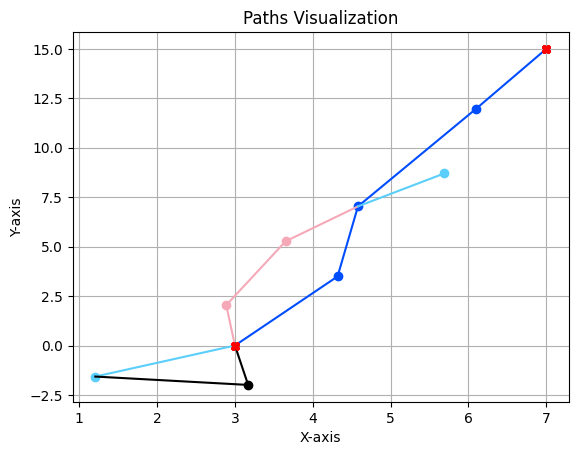

In [18]:
# RNG
#set_seed(24)

# Settings for the paths.
start_x = 3.0
start_y = 0.0
end_x = 7.0
end_y = 15.0
points_main = 5
points_alt = 5

# Settings - Graphing
graph_style_main = GraphStyle(line_color='#004DFF', line_style='-', node_color='#004DFF', node_shape='o', start_node_color='#000000', start_node_shape='*', end_node_color='#000000', end_node_shape='X')
graph_style_alt_a = GraphStyle(line_color='#F5A9B8', line_style='-', node_color='#F5A9B8', node_shape='o')
graph_style_alt_b = GraphStyle(line_color='#5BCEFA', line_style='-', node_color='#5BCEFA', node_shape='o')
graph_style_alt_c = GraphStyle(line_color='#000000', line_style='-', node_color='#000000', node_shape='o')
graph_styles_paths = [graph_style_main, graph_style_alt_a, graph_style_alt_b, graph_style_alt_c]

# Settings - Fuzz
fuzz_distance_main = 2.0
fuzz_distance_alt = 1.0
fuzz_distribution_main = stats.beta(a=9, b=5)
fuzz_distribution_alt = stats.beta(a=30, b=4)

# Settings - Cross-pathing

# Settings - Node Deletion
percent_nodes_deleted_b = 0.4
percent_nodes_deleted_c = 0.4
percent_nodes_deleted_d = 0.4

# Settings - Edge Deletion
percent_edges_deleted_b = 0.4
percent_edges_deleted_c = 0.4
percent_edges_deleted_d = 0.4

# Settings - Untangling
use_fixed_ends = True
pull_iterations = 8
pull_strength = 0.3
pull_distance = 2.0
push_iterations = 5
push_strength = 0.03
push_distance = 10.0
push_exponential_term = 2
nonconnected_push_force = 0.2
phases = 3
shunt_distance = 2
span = (end_x ** 2 + end_y ** 2) ** 0.5

using_fuzz = True
using_cross_pathing = True
using_node_deletion = True
using_edge_deletion = True
using_untangling = True

# Create start/end nodes.
def create_and_graph():
    start_node = Node(start_x, start_y)
    end_node = Node(end_x, end_y)

    # Create the paths.
    path_a = create_path(start_node, end_node, points_main)
    path_b = create_path(start_node, end_node, points_main)
    path_c = create_path(start_node, end_node, points_main)
    path_d = create_path(start_node, end_node, points_main)

    paths = [path_a, path_b, path_c, path_d]
    alt_paths = [path_b, path_c, path_d]

    # Post-process the path.
    if using_fuzz:
        fuzz_nodes(path_a, fuzz_distance_main, distribution=fuzz_distribution_main)
        fuzz_nodes(path_b, fuzz_distance_alt, distribution=fuzz_distribution_alt)
        fuzz_nodes(path_c, fuzz_distance_alt, distribution=fuzz_distribution_alt)
        fuzz_nodes(path_d, fuzz_distance_alt, distribution=fuzz_distribution_alt)

    # Cross-connect the paths, delete random nodes, then clean the nodes up.
    # Todo: Investigate if blocking up b and c causes any issues, or if it's fine to interleave their generation processes.
    if using_cross_pathing:
        path_b.add_edges(cross_connect_paths(path_a, path_b))
        path_c.add_edges(cross_connect_paths(path_a, path_c))
        path_d.add_edges(cross_connect_paths(path_c, path_d))

    if using_node_deletion:
        path_b.nodes = randomly_delete(path_b.nodes, percent=percent_nodes_deleted_b)
        path_c.nodes = randomly_delete(path_c.nodes, percent=percent_nodes_deleted_c)
        path_d.nodes = randomly_delete(path_d.nodes, percent=percent_nodes_deleted_d)

    if using_edge_deletion:
        path_b.edges = randomly_delete(path_b.edges, percent=percent_edges_deleted_b, protect_bounds=False)
        path_c.edges = randomly_delete(path_c.edges, percent=percent_edges_deleted_c, protect_bounds=False)
        path_d.edges = randomly_delete(path_d.edges, percent=percent_edges_deleted_d, protect_bounds=False)

    path_b.edges = cleanup_edges(path_b.edges, valid_nodes=path_a.nodes + path_b.nodes + path_c.nodes + path_d.nodes)
    path_c.edges = cleanup_edges(path_c.edges, valid_nodes=path_a.nodes + path_b.nodes + path_c.nodes + path_d.nodes)
    path_d.edges = cleanup_edges(path_d.edges, valid_nodes=path_a.nodes + path_b.nodes + path_c.nodes + path_d.nodes)

    # Remove any orphaned nodes from the alt path.
    cleanup_orphaned_nodes(path_a, alt_paths)

    # Set fixed nodes.
    if using_untangling:
        # Combine all edges in paths.
        edges = []
        for path in paths:
            edges.extend(path.edges)

        if use_fixed_ends:
            fixed = {path_a.nodes[0], path_a.nodes[-1]}
        else:
            fixed = OrderedSet()

        # Untangle the edges.
        untangle(
            edges,
            fixed=fixed,
            pull_iterations=pull_iterations,
            pull_strength=pull_strength,
            pull_distance=span / pull_distance,
            push_iterations=push_iterations,
            push_strength=push_strength,
            push_distance=span / push_distance,
            push_exponential_term=push_exponential_term,
            nonconnected_push_force=nonconnected_push_force,
            phases=phases,
            shunt_distance=shunt_distance
        )

    # Todo: Investigate how to introduce/maintain fuzz after untangling besides the below.
    # Post-untangle cleanup.
    # fuzz_nodes(path_a, fuzz_distance_main, distribution=fuzz_distribution_main)

    # Display the paths.
    axis = plot_paths(paths, graph_styles_paths)

    plt.show()

create_and_graph()